<a href="https://colab.research.google.com/github/juanpajaro/ia_salud_rnn_text_classification/blob/main/clinical_text_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import matplotlib.pyplot as plt

TensorFlow version: 2.19.0


In [2]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
datos = pd.read_csv('/content/datos_apnea.csv')
datos.head()

,EnfermedadActual,Apnea
0,ACUDE PACIENTE A CONSULTA CON CUADRO DE DELARA...,No
1,CUADRO DE CEFALEA GLOBAL INTENSIDAD MODERADA. ...,No
2,PACIENTE CON ANTECEDENTE DE HIPOTIRODISMO DE L...,NaN
3,PACIENTE DE 44 AÑOS DE EDAD QUIEN ASISTE A CON...,No
4,PACIENTE CON HIPOTIRODISMO DX EN EL EMBARAZO H...,No


In [4]:
datos["Apnea"].value_counts()

,count
Apnea,
No,57733


In [5]:
#count NaN in datos["Apnea"]
datos["Apnea"].isna().sum()

np.int64(42267)

In [6]:
#convert NaN in datos["Apnea"] to 1 and "No" to cero
datos["Apnea"] = datos["Apnea"].fillna(1)
datos["Apnea"] = datos["Apnea"].replace("No", 0)
datos["Apnea"].value_counts()

/tmp/ipython-input-3173026645.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  datos["Apnea"] = datos["Apnea"].replace("No", 0)


,count
Apnea,
0,57733
1,42267


In [7]:
#Ensure that "EnfermedadActual" column is of type string
datos['EnfermedadActual'] = datos['EnfermedadActual'].astype(str)

#convert the datos["Apnea"] column to label

#Split datos in train and test using pandas
train = datos.sample(frac=0.8, random_state=200)
test = datos.drop(train.index)

#Print shape of train and test
print(train.shape)
print(test.shape)

#print type of train and test
print(type(train))
print(type(test))

(80000, 2)
(20000, 2)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [8]:
#Create a TensorFlow dataset based on train df
train_dataset = tf.data.Dataset.from_tensor_slices((train['EnfermedadActual'].values, train["Apnea"]))

#Create a TensorFlow dataset based on test df
test_dataset = tf.data.Dataset.from_tensor_slices((test['EnfermedadActual'].values, test["Apnea"]))

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [10]:
for example, label in train_dataset.take(2):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"Paciente ocn antecedente de  hipotiroidismo, se le  habia solicitada   exograf\xc3\xada de  tiroides pro disfon\xc3\xada persitentte trae resultado ''Junio 1/2017:  ecpgraf+ia de tiroides: gl\xc3\xa1ndula tiroides aumentada de tama\xc3\xb1o, de forma y sitaucion  normal , contorno slubulados, en  zona inferior de l\xc3\xb3bulo tiroideso se visualiza n\xc3\xb3dulo  lobulado de contornos definidos,  heterogeneo , sin calcificciones,  que meide 17.2* 6* 8.6mm,   conclusion bocio nodular,  recomiendan seguimiento ecog\xc2\xb4rafico en seis meses,"
label:  0
text:  b"PACIENTE DE 52 A\xc3\x91OS, CON ANTECEDENTE DE SINDROME DE DOWN, DIABETES INSULINODENDIENTE , HIPOTIRIDISMO, ARTRITIS REUMATOIDEA EN CONTROL CON MEDICINA INTERNA PREPAGADA EN TRATAMIENTO CON CLOROQUINA 250MG DIA, PREDNISOLONA 5 MG DIA, INSULINA DEGLUDEC 18 UN DIA, INSULINA HUMALOG 5 UN DIA ASA 100MG DIA, GLUCAGON 1 AMPOLLA EN CASO DE HIPOGLICEMIA, CALCI O + VITA D 1 TABLETA DIA, TIROXINA 150 MCG SABADO Y DOMINGO TIROXI

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [12]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'PAciente con antecedente hipotiroidismo refiere no cuenta con medicacion por lo que asiste a consulta. PAciente refiere ha presentaod dolor en region inguinal derecho refiere ocaisonalmente irradiado a MID, no refere sangrado, no refiere nasueas, no vomito, no iarrea, no asociado a comidas, no otra sintomatologia asociada.'
 b"cuadro de 6 meses de sensacion de masa en axila derecha no aumento de tama\xc3\xb1o, asocia ultimos meses dolor en senos persistente, , a\xc3\xb1os atras dolor con mestruacion.''refiere ultimos 6 meses con auento de peso, en manejo con dieta y ejercicio"
 b'PACIENTE ASISTE A CONSULTA CON REPORTE DE PARACLINICOS, VER DESCRIPCION EN ANTECEDENTES, REFIERE TOS SECA CRONICA DE APROXIMADAMENTE 20 A\xc3\x91OS, EN EL MOMENTO REFIERE DISNEA DE GRANDES ESFUERZOS']

labels:  [0 0 1]


In [14]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [15]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'de', 'en', 'con', 'no', 'por', 'paciente', 'a',
       'que', 'refiere', 'y', 'niega', 'el', 'dolor', 'la', 'consulta',
       'aÑos', 'se', 'cuadro'], dtype='<U18')

In [16]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  7,   4,  39,  65,  10,   5, 978,   4,  96,   6,  43,   9,  29,
          8,  16,   7,  10,  33,   1,  14,   3,  68, 943,  99,  10,   1,
        168,   8,   1,   5,   1, 336,   5,  10,   1,   5, 560,   5,   1,
          5,  64,   8,   1,   5,  80,  84, 266,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [ 19,   2, 125,  35,   2,  79,   2, 422,   3,   1, 118,   5, 245,
          2,   1, 353, 211,  35,  14,   3,   1, 676,  28,   1,  14,   4,
          1, 211, 125,  35,   4,   1,   2, 146,   3,  30,   4, 229,  11,
        443,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,

In [17]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'PAciente con antecedente hipotiroidismo refiere no cuenta con medicacion por lo que asiste a consulta. PAciente refiere ha presentaod dolor en region inguinal derecho refiere ocaisonalmente irradiado a MID, no refere sangrado, no refiere nasueas, no vomito, no iarrea, no asociado a comidas, no otra sintomatologia asociada.'
Round-trip:  paciente con antecedente hipotiroidismo refiere no cuenta con medicacion por lo que asiste a consulta paciente refiere ha [UNK] dolor en region inguinal derecho refiere [UNK] irradiado a [UNK] no [UNK] sangrado no refiere [UNK] no vomito no [UNK] no asociado a [UNK] no otra sintomatologia asociada                                                

Original:  b"cuadro de 6 meses de sensacion de masa en axila derecha no aumento de tama\xc3\xb1o, asocia ultimos meses dolor en senos persistente, , a\xc3\xb1os atras dolor con mestruacion.''refiere ultimos 6 meses con auento de peso, en manejo con dieta y ejercicio"
Round-trip:  cuadro de 6 meses d

In [18]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [19]:
# predict on a sample text without padding.

sample_text = ('Paciente en urgencias, con dolor en el pecho.')

#Convertir el texto de entrada en un tensor de tipo tf.string
sample_text_tensor = tf.constant([sample_text])

#Realizar la predicción
predictions = model.predict(sample_text_tensor)

print(predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[-0.007809]


In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 187s 149ms/step - accuracy: 0.5763 - loss: 0.6738 - val_accuracy: 0.5802 - val_loss: 0.6780
Epoch 2/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 193s 154ms/step - accuracy: 0.5779 - loss: 0.6692 - val_accuracy: 0.5818 - val_loss: 0.6795


(0.0, 0.6800815850496292)

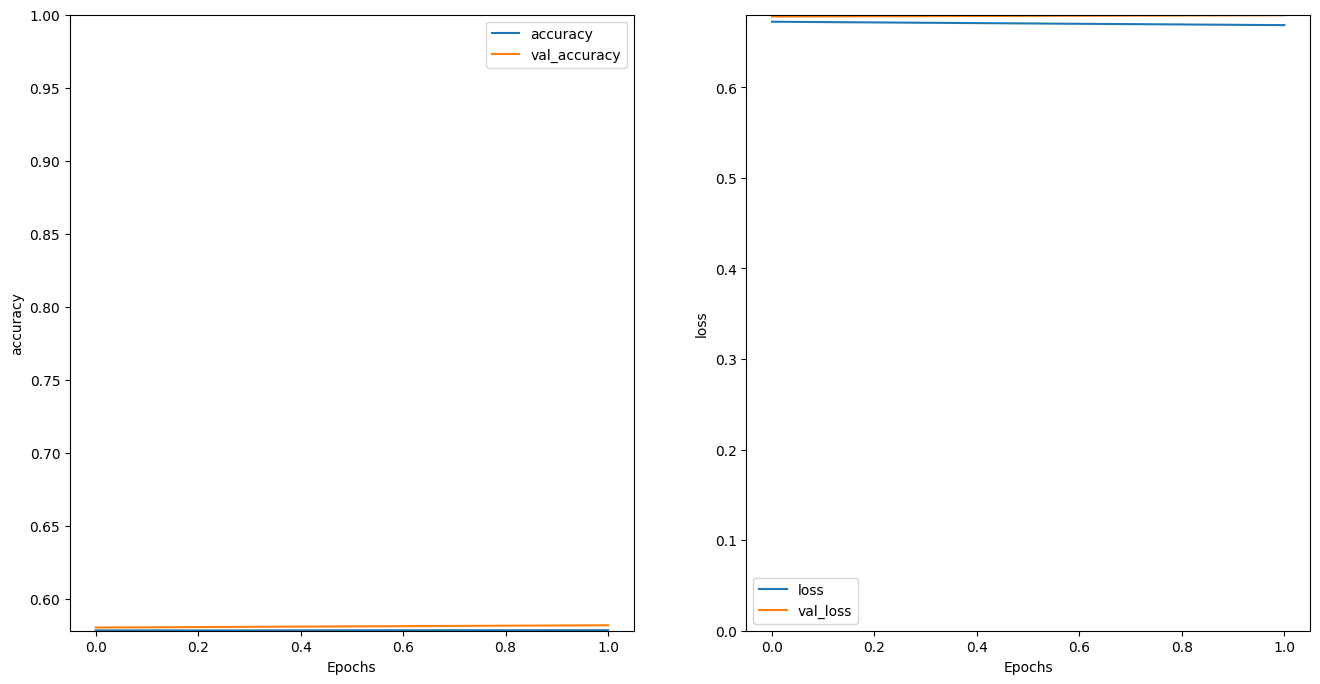

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)